# Generating Fashion Items using a Generative Adversarial Network

This notebook (associated with the following Medium post) displays the code for building a simple GAN (Generative Adversarial Network) in order to generate fashion items.

In this notebook we are using the following modules:

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading the data

In order to train this model we are using the [Fashion-MNIST dataset](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/). We discard the well-known MNIST dataset since it is a way too easy and simple dataset for the current Deep Learning landscape (MNIST can be predicted using only one pixel: https://gist.github.com/dgrtwo/aaef94ecc6a60cd50322c0054cc04478).

Fashion MNIST is composed by 10000 black and white images of fashion items of 28x28 resolution. This dataset is included in the Keras module.

First of all we load the data:

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

This dataset comes already splitted in two sets, one for training and one for validation:

In [3]:
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

Before starting to build our generative model let's explore a bit the dataset in order to have a better understanding of what we are working with. For instance, let's have a look to an image from the training set:

In [4]:
print(training_images[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [5]:
type(training_images[0])

numpy.ndarray

In [6]:
training_images[0].shape

(28, 28)

In [7]:
training_images[0].size

784

The data is presented as a matrix of 784 pixels (28x28) with values between 0 and 255.

In [8]:
print(training_labels[0])

9


The label is an integer. These are the ten classes we are working with and their associated integer:
* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

Using the matrix of integers we can plot the image we are working with:

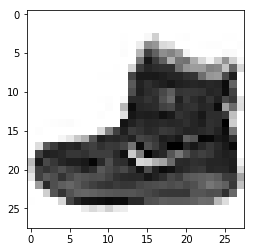

In [9]:
plt.imshow(training_images[0], cmap='Greys');

In [10]:
training_labels[0]

9

It is an ankle boot.

Neural network usually work better with normalized data so we proceed to transform these data:

In [11]:
x_train = (training_images.astype(np.float32) - 127.5)/127.5

In [12]:
x_test = (test_images.astype(np.float32) - 127.5)/127.5

Now the value of the pixels is a float between -1 and 1:

In [13]:
x_train[0]

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    

We can check this transformation doesn't affect the representation of the fashion item:

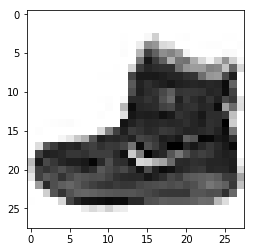

In [14]:
plt.imshow(x_train[0], cmap='Greys');

## Building the model

We are using the Adam optimizer:

In [15]:
from keras.optimizers import Adam
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

### Generator

We are first building the Generator **G**. The generator will take a random array of shape (examples, 100) with examples = number of example we want to build. Starting from this array it will apply a dense layer followed by a leaky relu three times and a final dense layer that fixes the size of the result from this net to 784 (the number of pixels we look for in our generated images).

In [16]:
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

def build_generator():
    generator=keras.Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
G = build_generator()
G.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
________________________________________________

### Discriminator

And finally we build the Discriminator **D** which tries to distinguish real and fake images. First it has a dense layer, a LeakyRELU and a dropout twice and then another dense. and LeakyRELU followed by a final dense layer formed by only one unit and using a sigmoid for activation since we are aiming to get a probability (probability the image is real):

In [17]:
def build_discriminator():
    discriminator=keras.Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
D =build_discriminator()
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

### Building the GAN

Finally we build the GAN model concantenating the two previous models. We ffed as an input the random array of noise and pass it to the generator in order to generate fake images. After this we pass this fake images to the discriminator. We keep using the Adam optimizer:

In [18]:
def build_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= keras.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = build_gan(D,G)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


We define a small function in order to be able to have a glance of how the generator keeps improving and improving along the epochs. This function uses the generator to build images from noise. Then plots the images and saves the result in a png image:

In [19]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

Finally we build a function to train the network. The function starts by loading the data (60000 images of 784 pixels). Afterwards it builds the GAN using the functions created above. Then the training process starts. For each element in the batch we follow the same process. We generate some random noise from a normal distribution and use the generator to generate images from this noise. We get a random sample from the real images of the batch and build new batches which mix real and fake images. We label the data in order to know which images are real and which generated. We pre-train the discriminator and then fix its parameters in order to train the generator:

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1
Instructions for updating:
Use tf.cast instead.


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 2


  1%|          | 1/128 [00:00<00:13,  9.71it/s]

Epoch 3


  2%|▏         | 2/128 [00:00<00:10, 11.80it/s]

Epoch 4


  2%|▏         | 2/128 [00:00<00:11, 11.14it/s]

Epoch 5


  1%|          | 1/128 [00:00<00:15,  8.30it/s]

Epoch 6


  2%|▏         | 2/128 [00:00<00:11, 11.11it/s]

Epoch 7


  1%|          | 1/128 [00:00<00:12,  9.84it/s]

Epoch 8


  1%|          | 1/128 [00:00<00:12,  9.89it/s]

Epoch 9


  1%|          | 1/128 [00:00<00:13,  9.26it/s]

Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 11


  1%|          | 1/128 [00:00<00:14,  8.60it/s]

Epoch 12


  1%|          | 1/128 [00:00<00:13,  9.68it/s]

Epoch 13


  1%|          | 1/128 [00:00<00:13,  9.53it/s]

Epoch 14


  2%|▏         | 2/128 [00:00<00:11, 11.11it/s]

Epoch 15


  1%|          | 1/128 [00:00<00:13,  9.58it/s]

Epoch 16


  1%|          | 1/128 [00:00<00:13,  9.62it/s]

Epoch 17


  2%|▏         | 2/128 [00:00<00:11, 11.24it/s]

Epoch 18


  2%|▏         | 2/128 [00:00<00:11, 11.29it/s]

Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:11, 11.25it/s]

Epoch 21


  2%|▏         | 2/128 [00:00<00:10, 11.70it/s]

Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 23


  2%|▏         | 2/128 [00:00<00:10, 12.29it/s]

Epoch 24


  2%|▏         | 2/128 [00:00<00:11, 10.90it/s]

Epoch 25


  2%|▏         | 2/128 [00:00<00:10, 12.12it/s]

Epoch 26


  2%|▏         | 2/128 [00:00<00:10, 11.96it/s]

Epoch 27


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 28


  2%|▏         | 2/128 [00:00<00:10, 12.20it/s]

Epoch 29


  2%|▏         | 2/128 [00:00<00:10, 12.13it/s]

Epoch 30


  2%|▏         | 2/128 [00:00<00:09, 12.61it/s]

Epoch 31


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 32


  2%|▏         | 2/128 [00:00<00:11, 11.35it/s]

Epoch 33


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 34


  2%|▏         | 2/128 [00:00<00:10, 11.55it/s]

Epoch 35


  2%|▏         | 2/128 [00:00<00:10, 11.48it/s]

Epoch 36


  2%|▏         | 2/128 [00:00<00:10, 12.20it/s]

Epoch 37


  2%|▏         | 2/128 [00:00<00:10, 11.95it/s]

Epoch 38


  2%|▏         | 2/128 [00:00<00:10, 12.28it/s]

Epoch 39


  1%|          | 1/128 [00:00<00:14,  8.79it/s]

Epoch 40


  1%|          | 1/128 [00:00<00:13,  9.47it/s]

Epoch 41


  1%|          | 1/128 [00:00<00:13,  9.33it/s]

Epoch 42


  1%|          | 1/128 [00:00<00:17,  7.23it/s]

Epoch 43


  2%|▏         | 2/128 [00:00<00:10, 12.24it/s]

Epoch 44


  2%|▏         | 2/128 [00:00<00:10, 12.07it/s]

Epoch 45


  2%|▏         | 2/128 [00:00<00:10, 12.21it/s]

Epoch 46


  2%|▏         | 2/128 [00:00<00:10, 11.63it/s]

Epoch 47


  2%|▏         | 2/128 [00:00<00:10, 12.18it/s]

Epoch 48


  2%|▏         | 2/128 [00:00<00:10, 11.96it/s]

Epoch 49


  2%|▏         | 2/128 [00:00<00:10, 12.05it/s]

Epoch 50


  2%|▏         | 2/128 [00:00<00:10, 12.09it/s]

Epoch 51


  2%|▏         | 2/128 [00:00<00:10, 12.38it/s]

Epoch 52


  2%|▏         | 2/128 [00:00<00:10, 11.91it/s]

Epoch 53


  2%|▏         | 2/128 [00:00<00:10, 12.20it/s]

Epoch 54


  2%|▏         | 2/128 [00:00<00:10, 12.18it/s]

Epoch 55


  2%|▏         | 2/128 [00:00<00:10, 12.09it/s]

Epoch 56


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 57


  2%|▏         | 2/128 [00:00<00:10, 12.14it/s]

Epoch 58


  2%|▏         | 2/128 [00:00<00:11, 10.70it/s]

Epoch 59


  2%|▏         | 2/128 [00:00<00:11, 11.22it/s]

Epoch 60


  1%|          | 1/128 [00:00<00:14,  8.65it/s]

Epoch 61


  1%|          | 1/128 [00:00<00:24,  5.22it/s]

Epoch 62


  2%|▏         | 2/128 [00:00<00:11, 11.17it/s]

Epoch 63


  2%|▏         | 2/128 [00:00<00:11, 11.40it/s]

Epoch 64


  2%|▏         | 2/128 [00:00<00:11, 11.26it/s]

Epoch 65


  2%|▏         | 2/128 [00:00<00:11, 11.22it/s]

Epoch 66


  1%|          | 1/128 [00:00<00:15,  8.38it/s]

Epoch 67


  2%|▏         | 2/128 [00:00<00:11, 11.07it/s]

Epoch 68


  2%|▏         | 2/128 [00:00<00:11, 10.72it/s]

Epoch 69


  2%|▏         | 2/128 [00:00<00:11, 10.77it/s]

Epoch 70


  1%|          | 1/128 [00:00<00:15,  8.37it/s]

Epoch 71


  1%|          | 1/128 [00:00<00:18,  6.86it/s]

Epoch 72


  2%|▏         | 2/128 [00:00<00:10, 12.11it/s]

Epoch 73


  1%|          | 1/128 [00:00<00:13,  9.75it/s]

Epoch 74


  2%|▏         | 2/128 [00:00<00:10, 11.56it/s]

Epoch 75


  2%|▏         | 2/128 [00:00<00:10, 11.93it/s]

Epoch 76


  2%|▏         | 2/128 [00:00<00:10, 12.14it/s]

Epoch 77


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 78


  2%|▏         | 2/128 [00:00<00:10, 12.22it/s]

Epoch 79


  2%|▏         | 2/128 [00:00<00:10, 12.37it/s]

Epoch 80


  2%|▏         | 2/128 [00:00<00:11, 11.40it/s]

Epoch 81


  2%|▏         | 2/128 [00:00<00:10, 11.82it/s]

Epoch 82


  2%|▏         | 2/128 [00:00<00:10, 11.93it/s]

Epoch 83


  2%|▏         | 2/128 [00:00<00:11, 10.70it/s]

Epoch 84


  2%|▏         | 2/128 [00:00<00:10, 12.26it/s]

Epoch 85


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 86


  2%|▏         | 2/128 [00:00<00:10, 12.09it/s]

Epoch 87


  2%|▏         | 2/128 [00:00<00:10, 11.47it/s]

Epoch 88


  2%|▏         | 2/128 [00:00<00:10, 12.15it/s]

Epoch 89


  2%|▏         | 2/128 [00:00<00:10, 12.49it/s]

Epoch 90


  1%|          | 1/128 [00:00<00:17,  7.13it/s]

Epoch 91


  2%|▏         | 2/128 [00:00<00:10, 11.78it/s]

Epoch 92


  2%|▏         | 2/128 [00:00<00:11, 11.30it/s]

Epoch 93


  2%|▏         | 2/128 [00:00<00:10, 11.78it/s]

Epoch 94


  2%|▏         | 2/128 [00:00<00:11, 11.01it/s]

Epoch 95


  2%|▏         | 2/128 [00:00<00:10, 12.04it/s]

Epoch 96


  2%|▏         | 2/128 [00:00<00:10, 12.10it/s]

Epoch 97


  2%|▏         | 2/128 [00:00<00:10, 11.91it/s]

Epoch 98


  2%|▏         | 2/128 [00:00<00:10, 12.11it/s]

Epoch 99


  2%|▏         | 2/128 [00:00<00:10, 12.21it/s]

Epoch 100


  2%|▏         | 2/128 [00:00<00:10, 11.58it/s]

Epoch 101


  2%|▏         | 2/128 [00:00<00:10, 11.75it/s]

Epoch 102


  2%|▏         | 2/128 [00:00<00:10, 12.23it/s]

Epoch 103


  2%|▏         | 2/128 [00:00<00:10, 12.21it/s]

Epoch 104


  2%|▏         | 2/128 [00:00<00:11, 11.33it/s]

Epoch 105


  2%|▏         | 2/128 [00:00<00:10, 11.87it/s]

Epoch 106


  2%|▏         | 2/128 [00:00<00:10, 11.47it/s]

Epoch 107


  2%|▏         | 2/128 [00:00<00:11, 11.35it/s]

Epoch 108


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 109


  2%|▏         | 2/128 [00:00<00:10, 11.76it/s]

Epoch 110


  2%|▏         | 2/128 [00:00<00:10, 11.75it/s]

Epoch 111


  2%|▏         | 2/128 [00:00<00:10, 11.73it/s]

Epoch 112


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 113


  2%|▏         | 2/128 [00:00<00:10, 11.96it/s]

Epoch 114


  2%|▏         | 2/128 [00:00<00:10, 11.62it/s]

Epoch 115


  2%|▏         | 2/128 [00:00<00:10, 12.22it/s]

Epoch 116


  2%|▏         | 2/128 [00:00<00:10, 12.08it/s]

Epoch 117


  2%|▏         | 2/128 [00:00<00:10, 11.80it/s]

Epoch 118


  2%|▏         | 2/128 [00:00<00:10, 11.58it/s]

Epoch 119


  2%|▏         | 2/128 [00:00<00:10, 11.78it/s]

Epoch 120


  2%|▏         | 2/128 [00:00<00:11, 11.39it/s]

Epoch 121


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 122


  2%|▏         | 2/128 [00:00<00:10, 11.69it/s]

Epoch 123


  1%|          | 1/128 [00:00<00:12,  9.81it/s]

Epoch 124


  1%|          | 1/128 [00:00<00:23,  5.38it/s]

Epoch 125


  2%|▏         | 2/128 [00:00<00:11, 10.96it/s]

Epoch 126


  1%|          | 1/128 [00:00<00:24,  5.21it/s]

Epoch 127


  1%|          | 1/128 [00:00<00:24,  5.21it/s]

Epoch 128


  1%|          | 1/128 [00:00<00:22,  5.56it/s]

Epoch 129


  1%|          | 1/128 [00:00<00:23,  5.45it/s]

Epoch 130


  1%|          | 1/128 [00:00<00:22,  5.53it/s]

Epoch 131


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 132


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 133


  1%|          | 1/128 [00:00<00:25,  5.08it/s]

Epoch 134


  1%|          | 1/128 [00:00<00:24,  5.28it/s]

Epoch 135


  1%|          | 1/128 [00:00<00:23,  5.32it/s]

Epoch 136


  1%|          | 1/128 [00:00<00:23,  5.38it/s]

Epoch 137


  1%|          | 1/128 [00:00<00:23,  5.43it/s]

Epoch 138


  1%|          | 1/128 [00:00<00:23,  5.33it/s]

Epoch 139


  1%|          | 1/128 [00:00<00:23,  5.39it/s]

Epoch 140


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 141


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 142


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 144


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 145


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 146


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 147


  2%|▏         | 2/128 [00:00<00:10, 11.55it/s]

Epoch 148


  2%|▏         | 2/128 [00:00<00:10, 11.60it/s]

Epoch 149


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 150


  2%|▏         | 2/128 [00:00<00:11, 10.91it/s]

Epoch 151


  2%|▏         | 2/128 [00:00<00:10, 11.61it/s]

Epoch 152


  2%|▏         | 2/128 [00:00<00:10, 11.84it/s]

Epoch 153


  2%|▏         | 2/128 [00:00<00:10, 11.82it/s]

Epoch 154


  2%|▏         | 2/128 [00:00<00:11, 11.38it/s]

Epoch 155


  2%|▏         | 2/128 [00:00<00:10, 11.74it/s]

Epoch 156


  1%|          | 1/128 [00:00<00:17,  7.28it/s]

Epoch 157


  2%|▏         | 2/128 [00:00<00:10, 11.57it/s]

Epoch 158


  2%|▏         | 2/128 [00:00<00:10, 11.77it/s]

Epoch 159


  2%|▏         | 2/128 [00:00<00:10, 11.79it/s]

Epoch 160


  1%|          | 1/128 [00:00<00:19,  6.68it/s]

Epoch 161


  2%|▏         | 2/128 [00:00<00:10, 11.77it/s]

Epoch 162


  2%|▏         | 2/128 [00:00<00:10, 11.92it/s]

Epoch 163


  1%|          | 1/128 [00:00<00:13,  9.69it/s]

Epoch 164


  2%|▏         | 2/128 [00:00<00:10, 11.54it/s]

Epoch 165


  2%|▏         | 2/128 [00:00<00:10, 11.76it/s]

Epoch 166


  2%|▏         | 2/128 [00:00<00:10, 11.72it/s]

Epoch 167


  2%|▏         | 2/128 [00:00<00:11, 11.10it/s]

Epoch 168


  2%|▏         | 2/128 [00:00<00:10, 12.19it/s]

Epoch 169


  2%|▏         | 2/128 [00:00<00:10, 12.02it/s]

Epoch 170


  2%|▏         | 2/128 [00:00<00:10, 11.73it/s]

Epoch 171


  2%|▏         | 2/128 [00:00<00:10, 12.12it/s]

Epoch 172


  2%|▏         | 2/128 [00:00<00:11, 10.83it/s]

Epoch 173


  2%|▏         | 2/128 [00:00<00:11, 10.94it/s]

Epoch 174


  2%|▏         | 2/128 [00:00<00:10, 11.88it/s]

Epoch 175


  2%|▏         | 2/128 [00:00<00:10, 11.76it/s]

Epoch 176


  2%|▏         | 2/128 [00:00<00:11, 11.22it/s]

Epoch 177


  2%|▏         | 2/128 [00:00<00:10, 12.11it/s]

Epoch 178


  2%|▏         | 2/128 [00:00<00:10, 11.85it/s]

Epoch 179


  2%|▏         | 2/128 [00:00<00:10, 12.15it/s]

Epoch 180


  2%|▏         | 2/128 [00:00<00:10, 11.71it/s]

Epoch 181


  2%|▏         | 2/128 [00:00<00:10, 11.84it/s]

Epoch 182


  2%|▏         | 2/128 [00:00<00:10, 12.41it/s]

Epoch 183


  2%|▏         | 2/128 [00:00<00:10, 11.83it/s]

Epoch 184


  2%|▏         | 2/128 [00:00<00:10, 12.24it/s]

Epoch 185


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 186


  2%|▏         | 2/128 [00:00<00:10, 12.13it/s]

Epoch 187


  2%|▏         | 2/128 [00:00<00:10, 12.00it/s]

Epoch 188


  2%|▏         | 2/128 [00:00<00:10, 11.78it/s]

Epoch 189


  2%|▏         | 2/128 [00:00<00:10, 12.11it/s]

Epoch 190


  2%|▏         | 2/128 [00:00<00:10, 11.57it/s]

Epoch 191


  2%|▏         | 2/128 [00:00<00:10, 12.05it/s]

Epoch 192


  2%|▏         | 2/128 [00:00<00:10, 11.71it/s]

Epoch 193


  2%|▏         | 2/128 [00:00<00:10, 11.75it/s]

Epoch 194


  2%|▏         | 2/128 [00:00<00:10, 11.72it/s]

Epoch 195


  2%|▏         | 2/128 [00:00<00:10, 11.81it/s]

Epoch 196


  2%|▏         | 2/128 [00:00<00:10, 11.73it/s]

Epoch 197


  2%|▏         | 2/128 [00:00<00:10, 11.90it/s]

Epoch 198


  2%|▏         | 2/128 [00:00<00:10, 11.46it/s]

Epoch 199


  2%|▏         | 2/128 [00:00<00:10, 12.11it/s]

Epoch 200


  2%|▏         | 2/128 [00:00<00:10, 11.65it/s]

Epoch 201


  2%|▏         | 2/128 [00:00<00:11, 10.60it/s]

Epoch 202


  2%|▏         | 2/128 [00:00<00:12, 10.26it/s]

Epoch 203


  1%|          | 1/128 [00:00<00:12,  9.93it/s]

Epoch 204


  2%|▏         | 2/128 [00:00<00:12, 10.49it/s]

Epoch 205


  2%|▏         | 2/128 [00:00<00:12, 10.36it/s]

Epoch 206


  2%|▏         | 2/128 [00:00<00:11, 10.59it/s]

Epoch 207


  2%|▏         | 2/128 [00:00<00:11, 10.60it/s]

Epoch 208


  1%|          | 1/128 [00:00<00:12,  9.96it/s]

Epoch 209


  2%|▏         | 2/128 [00:00<00:12, 10.40it/s]

Epoch 210


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 211


  2%|▏         | 2/128 [00:00<00:12, 10.40it/s]

Epoch 212


  2%|▏         | 2/128 [00:00<00:11, 10.54it/s]

Epoch 213


  2%|▏         | 2/128 [00:00<00:12, 10.39it/s]

Epoch 214


  1%|          | 1/128 [00:00<00:13,  9.35it/s]

Epoch 215


  2%|▏         | 2/128 [00:00<00:11, 10.51it/s]

Epoch 216


  2%|▏         | 2/128 [00:00<00:12, 10.36it/s]

Epoch 217


  1%|          | 1/128 [00:00<00:12,  9.80it/s]

Epoch 218


  1%|          | 1/128 [00:00<00:15,  7.99it/s]

Epoch 219


  1%|          | 1/128 [00:00<00:12,  9.86it/s]

Epoch 220


  2%|▏         | 2/128 [00:00<00:11, 10.96it/s]

Epoch 221


  1%|          | 1/128 [00:00<00:16,  7.64it/s]

Epoch 222


  1%|          | 1/128 [00:00<00:13,  9.25it/s]

Epoch 223


  1%|          | 1/128 [00:00<00:15,  8.22it/s]

Epoch 224


  1%|          | 1/128 [00:00<00:18,  6.77it/s]

Epoch 225


  2%|▏         | 2/128 [00:00<00:11, 10.92it/s]

Epoch 226


  2%|▏         | 2/128 [00:00<00:11, 11.09it/s]

Epoch 227


  2%|▏         | 2/128 [00:00<00:10, 12.09it/s]

Epoch 228


  2%|▏         | 2/128 [00:00<00:10, 11.98it/s]

Epoch 229


  2%|▏         | 2/128 [00:00<00:10, 12.06it/s]

Epoch 230


  2%|▏         | 2/128 [00:00<00:10, 11.96it/s]

Epoch 231


  2%|▏         | 2/128 [00:00<00:11, 10.66it/s]

Epoch 232


  2%|▏         | 2/128 [00:00<00:11, 11.38it/s]

Epoch 233


  2%|▏         | 2/128 [00:00<00:11, 10.56it/s]

Epoch 234


  2%|▏         | 2/128 [00:00<00:11, 10.99it/s]

Epoch 235


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

Epoch 236


  2%|▏         | 2/128 [00:00<00:10, 11.89it/s]

Epoch 237


  2%|▏         | 2/128 [00:00<00:10, 11.57it/s]

Epoch 238


  2%|▏         | 2/128 [00:00<00:10, 12.35it/s]

Epoch 239


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 240


  2%|▏         | 2/128 [00:00<00:11, 11.32it/s]

Epoch 241


  2%|▏         | 2/128 [00:00<00:10, 11.84it/s]

Epoch 242


  2%|▏         | 2/128 [00:00<00:10, 11.52it/s]

Epoch 243


  2%|▏         | 2/128 [00:00<00:10, 12.02it/s]

Epoch 244


  2%|▏         | 2/128 [00:00<00:10, 11.68it/s]

Epoch 245


  2%|▏         | 2/128 [00:00<00:10, 11.88it/s]

Epoch 246


  2%|▏         | 2/128 [00:00<00:10, 12.46it/s]

Epoch 247


  2%|▏         | 2/128 [00:00<00:10, 11.79it/s]

Epoch 248


  2%|▏         | 2/128 [00:00<00:10, 11.88it/s]

Epoch 249


  2%|▏         | 2/128 [00:00<00:10, 11.92it/s]

Epoch 250


  2%|▏         | 2/128 [00:00<00:10, 12.20it/s]

Epoch 251


  2%|▏         | 2/128 [00:00<00:10, 11.76it/s]

Epoch 252


  2%|▏         | 2/128 [00:00<00:10, 12.30it/s]

Epoch 253


  2%|▏         | 2/128 [00:00<00:10, 11.79it/s]

Epoch 254


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 255


  2%|▏         | 2/128 [00:00<00:10, 11.72it/s]

Epoch 256


  2%|▏         | 2/128 [00:00<00:10, 11.94it/s]

Epoch 257


  2%|▏         | 2/128 [00:00<00:10, 11.94it/s]

Epoch 258


  2%|▏         | 2/128 [00:00<00:10, 11.87it/s]

Epoch 259


  2%|▏         | 2/128 [00:00<00:10, 11.81it/s]

Epoch 260


  2%|▏         | 2/128 [00:00<00:10, 11.66it/s]

Epoch 261


  2%|▏         | 2/128 [00:00<00:11, 11.38it/s]

Epoch 262


  2%|▏         | 2/128 [00:00<00:10, 11.54it/s]

Epoch 263


  2%|▏         | 2/128 [00:00<00:10, 11.80it/s]

Epoch 264


  2%|▏         | 2/128 [00:00<00:10, 11.81it/s]

Epoch 265


  2%|▏         | 2/128 [00:00<00:10, 12.00it/s]

Epoch 266


  2%|▏         | 2/128 [00:00<00:10, 11.94it/s]

Epoch 267


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 268


  2%|▏         | 2/128 [00:00<00:10, 12.18it/s]

Epoch 269


  2%|▏         | 2/128 [00:00<00:10, 11.79it/s]

Epoch 270


  2%|▏         | 2/128 [00:00<00:10, 12.30it/s]

Epoch 271


  2%|▏         | 2/128 [00:00<00:10, 12.28it/s]

Epoch 272


  2%|▏         | 2/128 [00:00<00:10, 11.91it/s]

Epoch 273


  2%|▏         | 2/128 [00:00<00:10, 11.76it/s]

Epoch 274


  2%|▏         | 2/128 [00:00<00:10, 12.19it/s]

Epoch 275


  2%|▏         | 2/128 [00:00<00:10, 12.05it/s]

Epoch 276


  2%|▏         | 2/128 [00:00<00:10, 11.95it/s]

Epoch 277


  2%|▏         | 2/128 [00:00<00:10, 12.00it/s]

Epoch 278


  2%|▏         | 2/128 [00:00<00:10, 11.63it/s]

Epoch 279


  2%|▏         | 2/128 [00:00<00:10, 11.98it/s]

Epoch 280


  2%|▏         | 2/128 [00:00<00:10, 11.61it/s]

Epoch 281


  2%|▏         | 2/128 [00:00<00:10, 11.77it/s]

Epoch 282


  2%|▏         | 2/128 [00:00<00:10, 11.65it/s]

Epoch 283


  2%|▏         | 2/128 [00:00<00:10, 11.89it/s]

Epoch 284


  2%|▏         | 2/128 [00:00<00:10, 12.08it/s]

Epoch 285


  2%|▏         | 2/128 [00:00<00:10, 11.68it/s]

Epoch 286


  2%|▏         | 2/128 [00:00<00:10, 11.53it/s]

Epoch 287


  2%|▏         | 2/128 [00:00<00:10, 11.51it/s]

Epoch 288


  2%|▏         | 2/128 [00:00<00:10, 12.04it/s]

Epoch 289


  2%|▏         | 2/128 [00:00<00:11, 11.24it/s]

Epoch 290


  1%|          | 1/128 [00:00<00:16,  7.59it/s]

Epoch 291


  2%|▏         | 2/128 [00:00<00:11, 11.34it/s]

Epoch 292


  2%|▏         | 2/128 [00:00<00:11, 10.69it/s]

Epoch 293


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 294


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 295


  2%|▏         | 2/128 [00:00<00:12, 10.44it/s]

Epoch 296


  2%|▏         | 2/128 [00:00<00:11, 10.73it/s]

Epoch 297


  2%|▏         | 2/128 [00:00<00:11, 10.83it/s]

Epoch 298


  2%|▏         | 2/128 [00:00<00:11, 10.87it/s]

Epoch 299


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 300


  2%|▏         | 2/128 [00:00<00:11, 10.72it/s]

Epoch 301


  2%|▏         | 2/128 [00:00<00:11, 11.03it/s]

Epoch 302


  1%|          | 1/128 [00:00<00:12,  9.98it/s]

Epoch 303


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 304


  2%|▏         | 2/128 [00:00<00:11, 10.75it/s]

Epoch 305


  2%|▏         | 2/128 [00:00<00:11, 10.89it/s]

Epoch 306


  2%|▏         | 2/128 [00:00<00:12, 10.48it/s]

Epoch 307


  2%|▏         | 2/128 [00:00<00:11, 10.74it/s]

Epoch 308


  2%|▏         | 2/128 [00:00<00:11, 10.87it/s]

Epoch 309


  2%|▏         | 2/128 [00:00<00:11, 10.69it/s]

Epoch 310


  2%|▏         | 2/128 [00:00<00:11, 10.82it/s]

Epoch 311


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 312


  1%|          | 1/128 [00:00<00:13,  9.46it/s]

Epoch 313


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

Epoch 314


  2%|▏         | 2/128 [00:00<00:11, 10.68it/s]

Epoch 315


  2%|▏         | 2/128 [00:00<00:12, 10.39it/s]

Epoch 316


  1%|          | 1/128 [00:00<00:16,  7.93it/s]

Epoch 317


  2%|▏         | 2/128 [00:00<00:12, 10.13it/s]

Epoch 318


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 319


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 320


  1%|          | 1/128 [00:00<00:13,  9.71it/s]

Epoch 321


  2%|▏         | 2/128 [00:00<00:11, 10.73it/s]

Epoch 322


  2%|▏         | 2/128 [00:00<00:12, 10.46it/s]

Epoch 323


  1%|          | 1/128 [00:00<00:12,  9.97it/s]

Epoch 324


  1%|          | 1/128 [00:00<00:12,  9.84it/s]

Epoch 325


  2%|▏         | 2/128 [00:00<00:12, 10.49it/s]

Epoch 326


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 327


  1%|          | 1/128 [00:00<00:12,  9.90it/s]

Epoch 328


  2%|▏         | 2/128 [00:00<00:12, 10.29it/s]

Epoch 329


  1%|          | 1/128 [00:00<00:12,  9.89it/s]

Epoch 330


  2%|▏         | 2/128 [00:00<00:11, 10.56it/s]

Epoch 331


  2%|▏         | 2/128 [00:00<00:12, 10.45it/s]

Epoch 332


  1%|          | 1/128 [00:00<00:12,  9.88it/s]

Epoch 333


  2%|▏         | 2/128 [00:00<00:12, 10.48it/s]

Epoch 334


  1%|          | 1/128 [00:00<00:14,  9.06it/s]

Epoch 335


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 336


  2%|▏         | 2/128 [00:00<00:12, 10.27it/s]

Epoch 337


  2%|▏         | 2/128 [00:00<00:11, 10.68it/s]

Epoch 338


  2%|▏         | 2/128 [00:00<00:12, 10.24it/s]

Epoch 339


  2%|▏         | 2/128 [00:00<00:11, 10.53it/s]

Epoch 340


  2%|▏         | 2/128 [00:00<00:12, 10.16it/s]

Epoch 341


  1%|          | 1/128 [00:00<00:12,  9.96it/s]

Epoch 342


  1%|          | 1/128 [00:00<00:14,  8.49it/s]

Epoch 343


  2%|▏         | 2/128 [00:00<00:12, 10.20it/s]

Epoch 344


  1%|          | 1/128 [00:00<00:14,  8.82it/s]

Epoch 345


  2%|▏         | 2/128 [00:00<00:12,  9.79it/s]

Epoch 346


  1%|          | 1/128 [00:00<00:13,  9.13it/s]

Epoch 347


  1%|          | 1/128 [00:00<00:14,  8.62it/s]

Epoch 348


  1%|          | 1/128 [00:00<00:14,  8.91it/s]

Epoch 349


  2%|▏         | 2/128 [00:00<00:12, 10.24it/s]

Epoch 350


  2%|▏         | 2/128 [00:00<00:12, 10.32it/s]

Epoch 351


  2%|▏         | 2/128 [00:00<00:12, 10.45it/s]

Epoch 352


  2%|▏         | 2/128 [00:00<00:12, 10.24it/s]

Epoch 353


  1%|          | 1/128 [00:00<00:13,  9.44it/s]

Epoch 354


  2%|▏         | 2/128 [00:00<00:12, 10.43it/s]

Epoch 355


  1%|          | 1/128 [00:00<00:12,  9.96it/s]

Epoch 356


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 357


  1%|          | 1/128 [00:00<00:13,  9.63it/s]

Epoch 358


  2%|▏         | 2/128 [00:00<00:12, 10.37it/s]

Epoch 359


  2%|▏         | 2/128 [00:00<00:12, 10.32it/s]

Epoch 360


  1%|          | 1/128 [00:00<00:13,  9.07it/s]

Epoch 361


  2%|▏         | 2/128 [00:00<00:12, 10.33it/s]

Epoch 362


  2%|▏         | 2/128 [00:00<00:11, 10.54it/s]

Epoch 363


  2%|▏         | 2/128 [00:00<00:12, 10.13it/s]

Epoch 364


  2%|▏         | 2/128 [00:00<00:12,  9.72it/s]

Epoch 365


  1%|          | 1/128 [00:00<00:13,  9.37it/s]

Epoch 366


  1%|          | 1/128 [00:00<00:12,  9.93it/s]

Epoch 367


  1%|          | 1/128 [00:00<00:13,  9.43it/s]

Epoch 368


  2%|▏         | 2/128 [00:00<00:12, 10.23it/s]

Epoch 369


  1%|          | 1/128 [00:00<00:20,  6.30it/s]

Epoch 370


  2%|▏         | 2/128 [00:00<00:10, 11.84it/s]

Epoch 371


  2%|▏         | 2/128 [00:00<00:10, 12.10it/s]

Epoch 372


  2%|▏         | 2/128 [00:00<00:11, 11.41it/s]

Epoch 373


  2%|▏         | 2/128 [00:00<00:10, 11.52it/s]

Epoch 374


  2%|▏         | 2/128 [00:00<00:10, 11.62it/s]

Epoch 375


  2%|▏         | 2/128 [00:00<00:10, 11.87it/s]

Epoch 376


  2%|▏         | 2/128 [00:00<00:10, 11.87it/s]

Epoch 377


  2%|▏         | 2/128 [00:00<00:10, 11.81it/s]

Epoch 378


  2%|▏         | 2/128 [00:00<00:10, 11.70it/s]

Epoch 379


  2%|▏         | 2/128 [00:00<00:10, 11.80it/s]

Epoch 380


  2%|▏         | 2/128 [00:00<00:10, 11.78it/s]

Epoch 381


  2%|▏         | 2/128 [00:00<00:10, 11.61it/s]

Epoch 382


  2%|▏         | 2/128 [00:00<00:10, 11.74it/s]

Epoch 383


  2%|▏         | 2/128 [00:00<00:10, 11.80it/s]

Epoch 384


  1%|          | 1/128 [00:00<00:13,  9.65it/s]

Epoch 385


  2%|▏         | 2/128 [00:00<00:11, 11.19it/s]

Epoch 386


  1%|          | 1/128 [00:00<00:13,  9.56it/s]

Epoch 387


  2%|▏         | 2/128 [00:00<00:10, 11.88it/s]

Epoch 388


  2%|▏         | 2/128 [00:00<00:10, 11.95it/s]

Epoch 389


  2%|▏         | 2/128 [00:00<00:10, 11.86it/s]

Epoch 390


  2%|▏         | 2/128 [00:00<00:10, 11.68it/s]

Epoch 391


  2%|▏         | 2/128 [00:00<00:10, 11.50it/s]

Epoch 392


  2%|▏         | 2/128 [00:00<00:11, 11.45it/s]

Epoch 393


  2%|▏         | 2/128 [00:00<00:10, 12.03it/s]

Epoch 394


  2%|▏         | 2/128 [00:00<00:10, 11.96it/s]

Epoch 395


  1%|          | 1/128 [00:00<00:13,  9.68it/s]

Epoch 396


  2%|▏         | 2/128 [00:00<00:10, 11.52it/s]

Epoch 397


  2%|▏         | 2/128 [00:00<00:11, 11.38it/s]

Epoch 398


  2%|▏         | 2/128 [00:00<00:10, 11.82it/s]

Epoch 399


  2%|▏         | 2/128 [00:00<00:10, 11.65it/s]

Epoch 400


100%|██████████| 128/128 [00:10<00:00, 12.00it/s]
/Users/arturosanchezpalacio/Entornos virtuales/notebooks/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


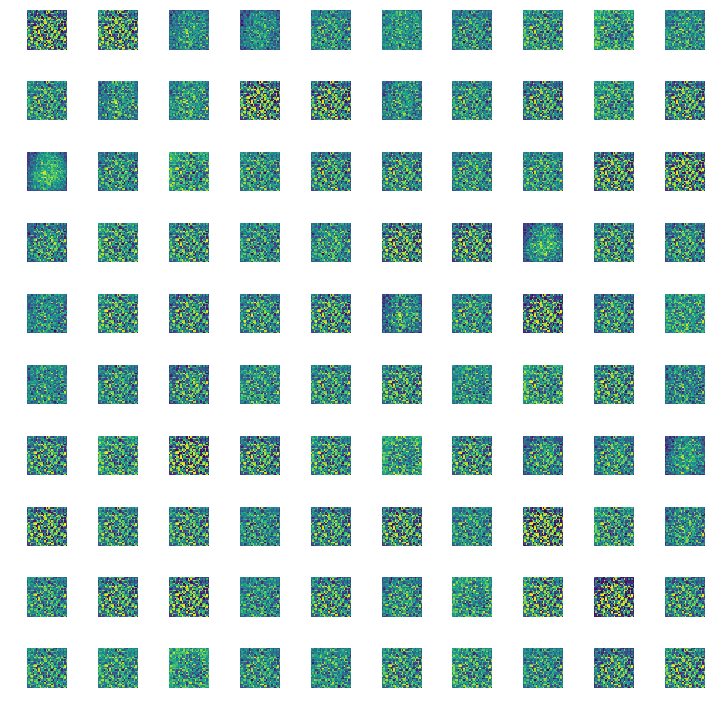

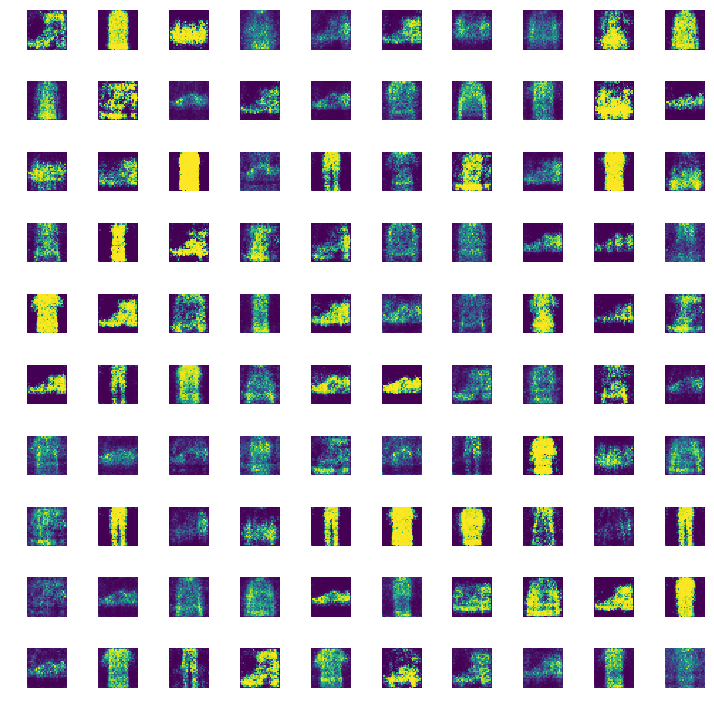

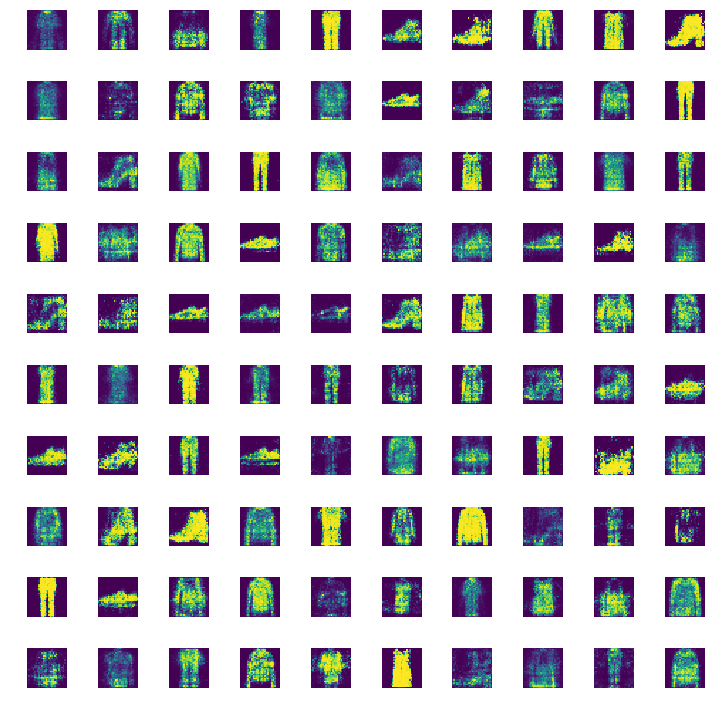

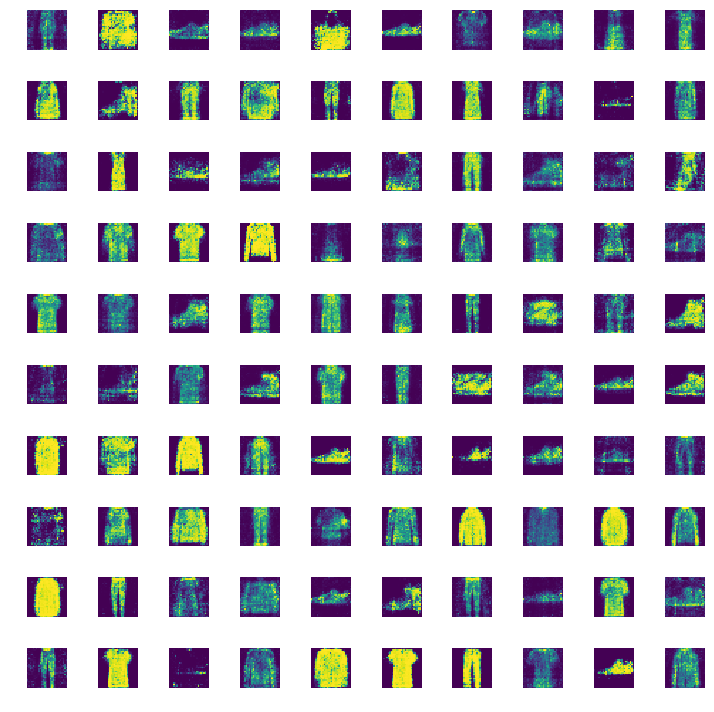

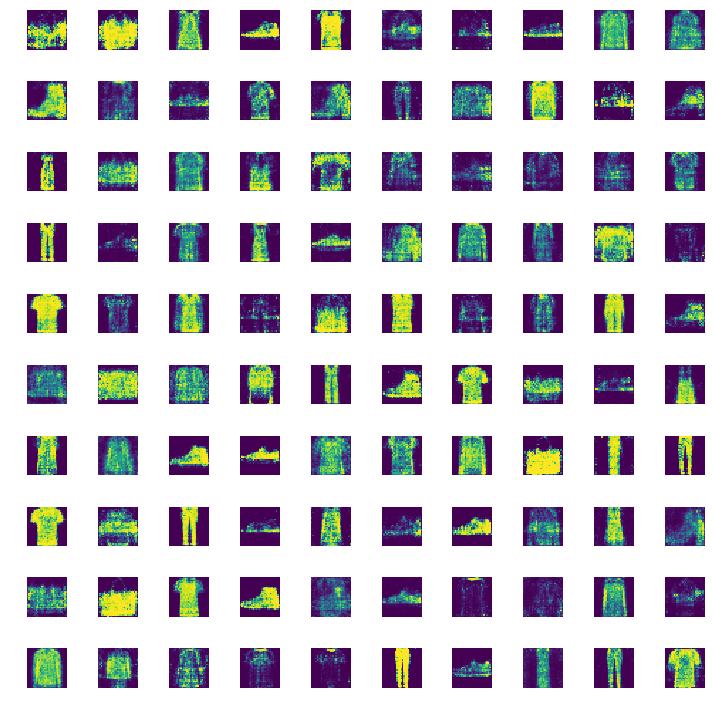

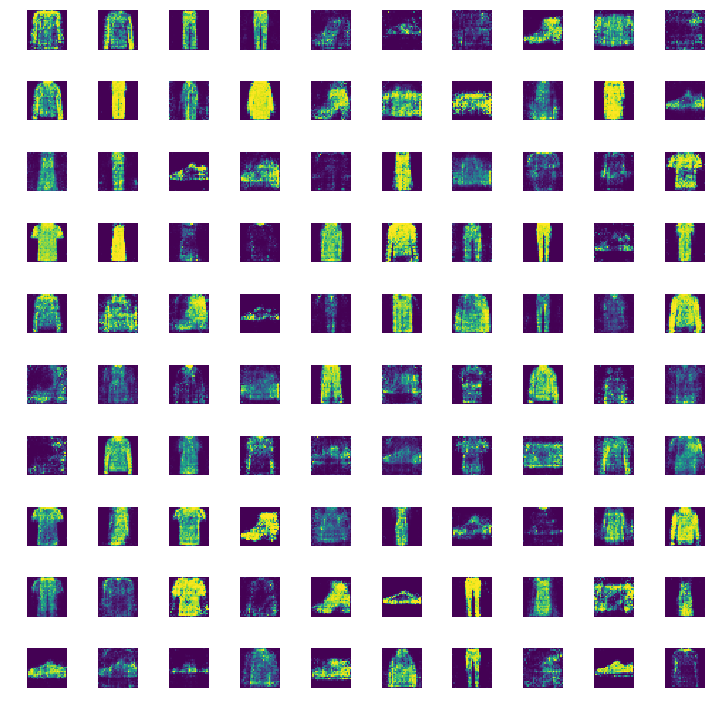

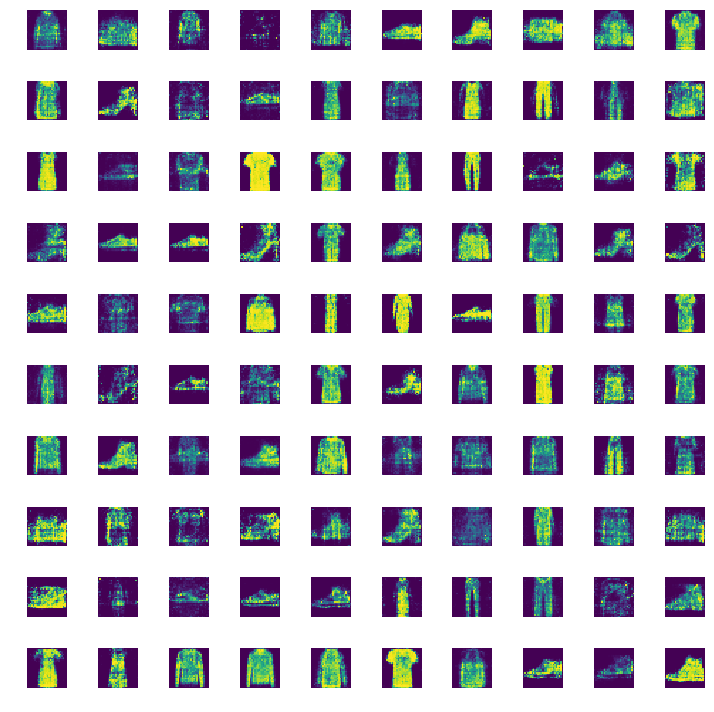

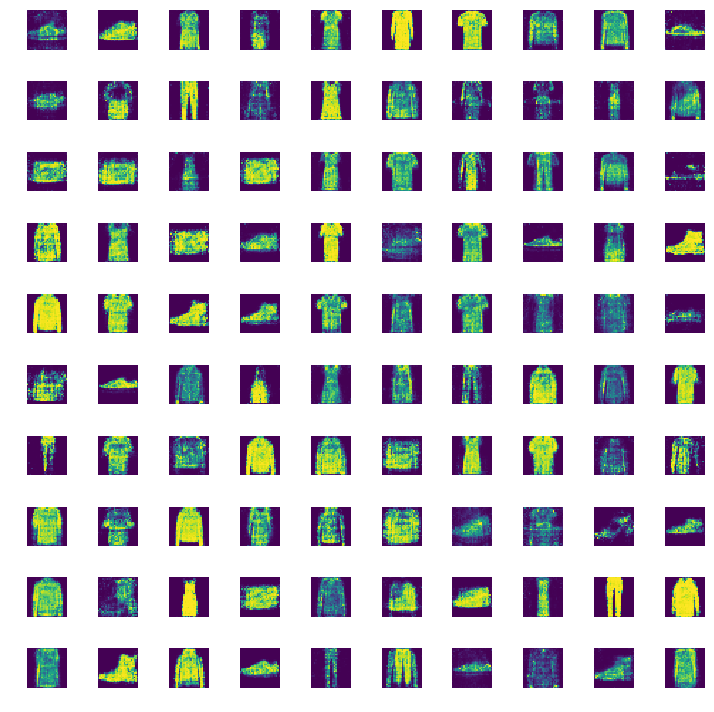

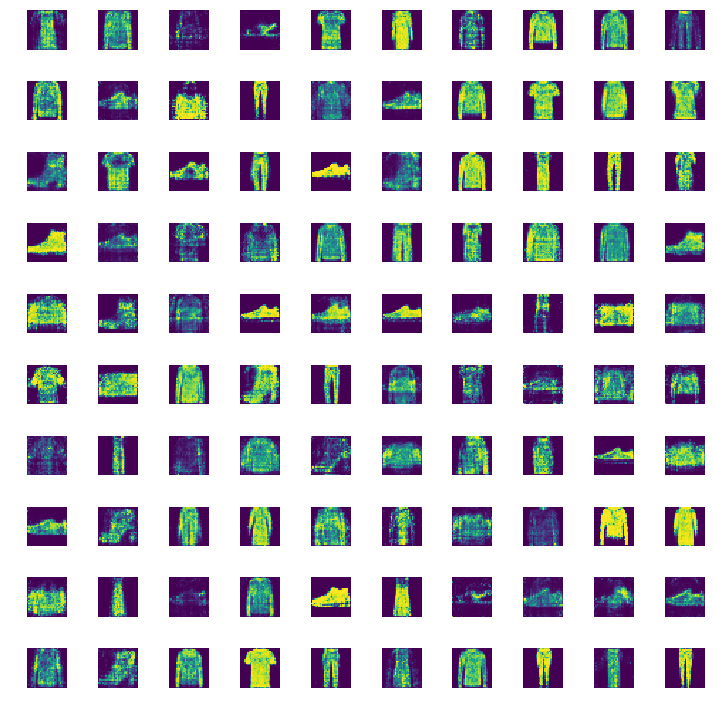

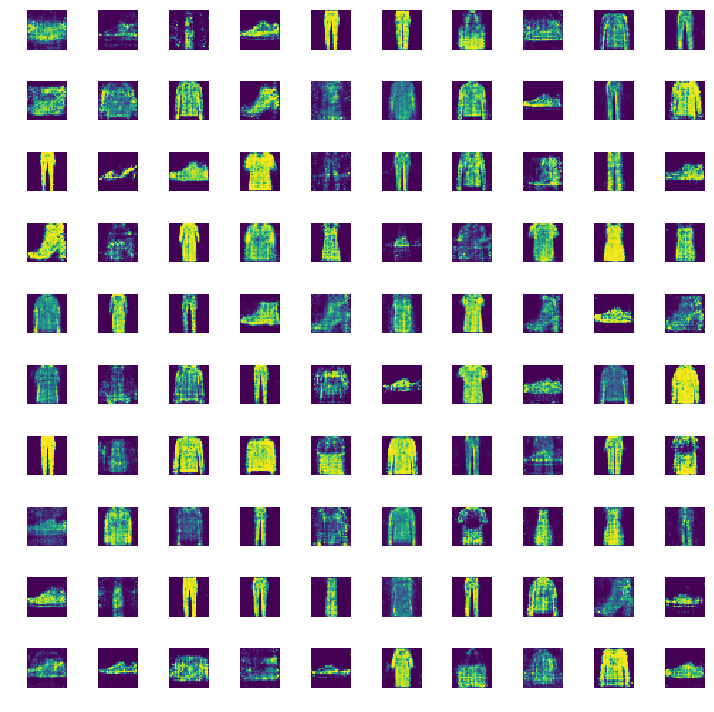

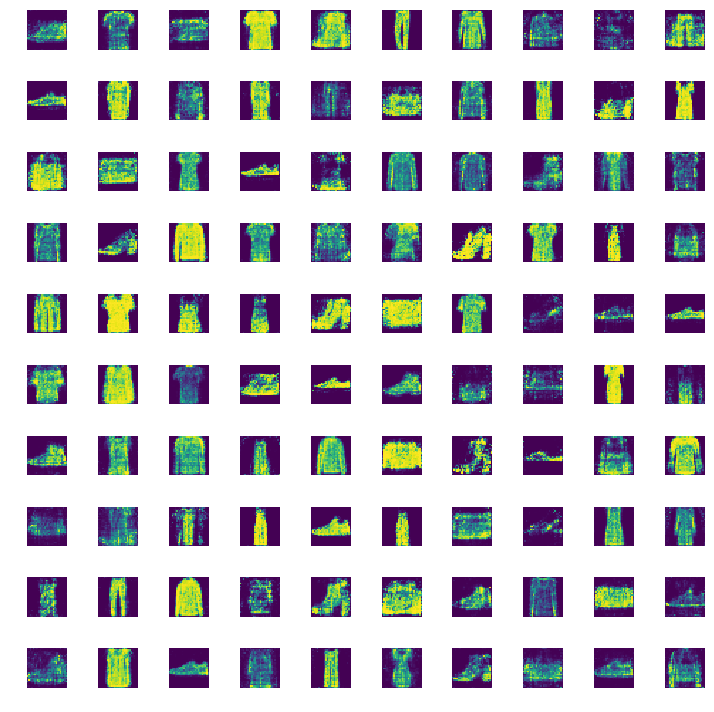

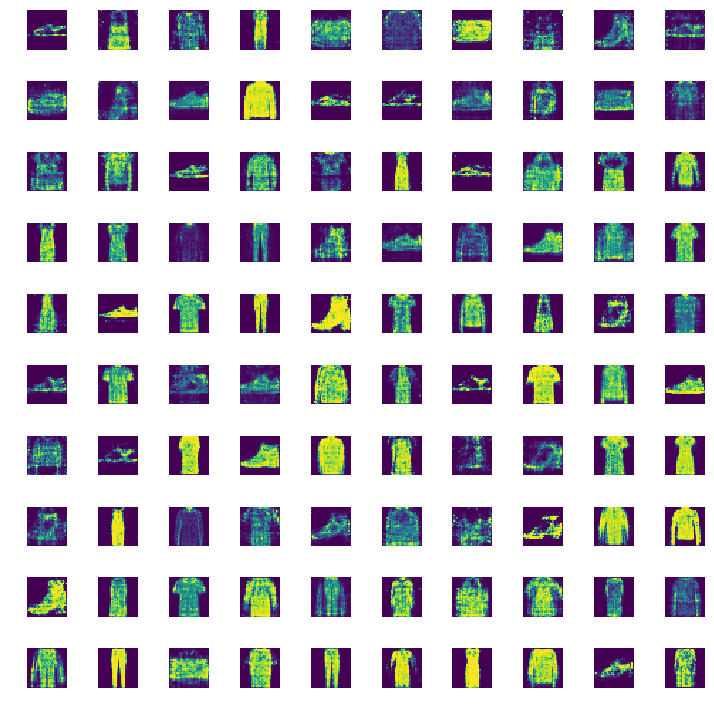

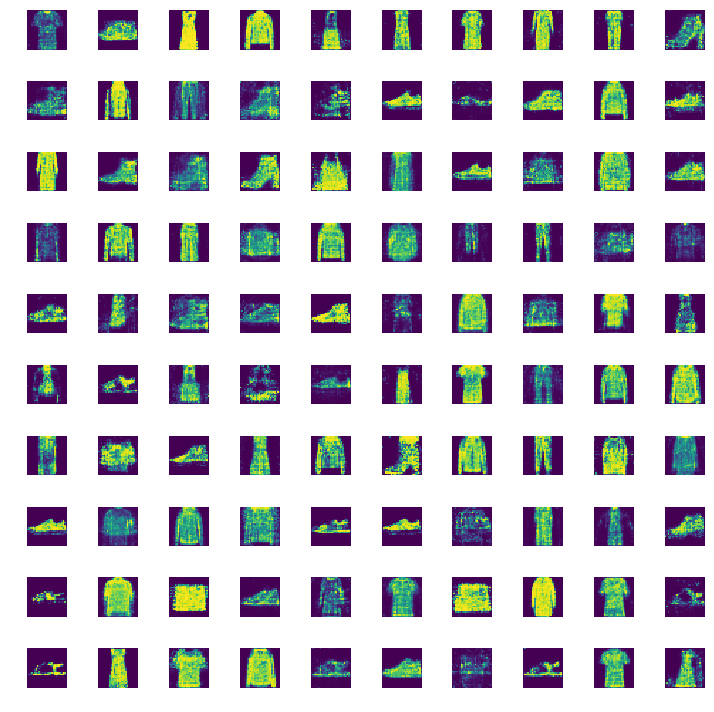

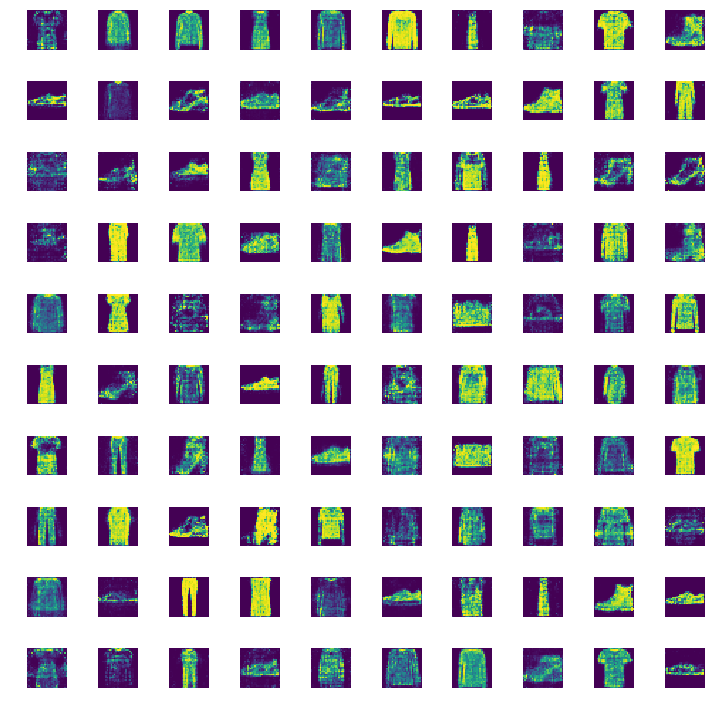

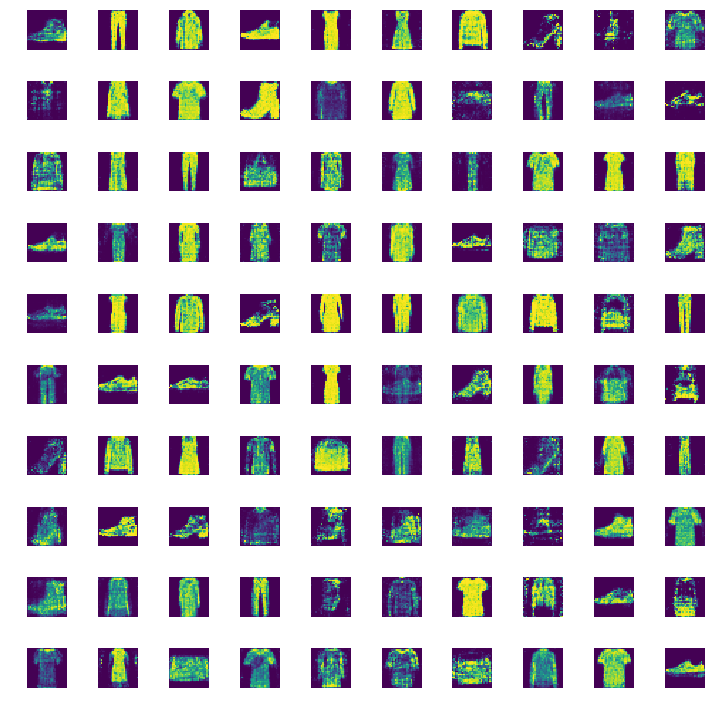

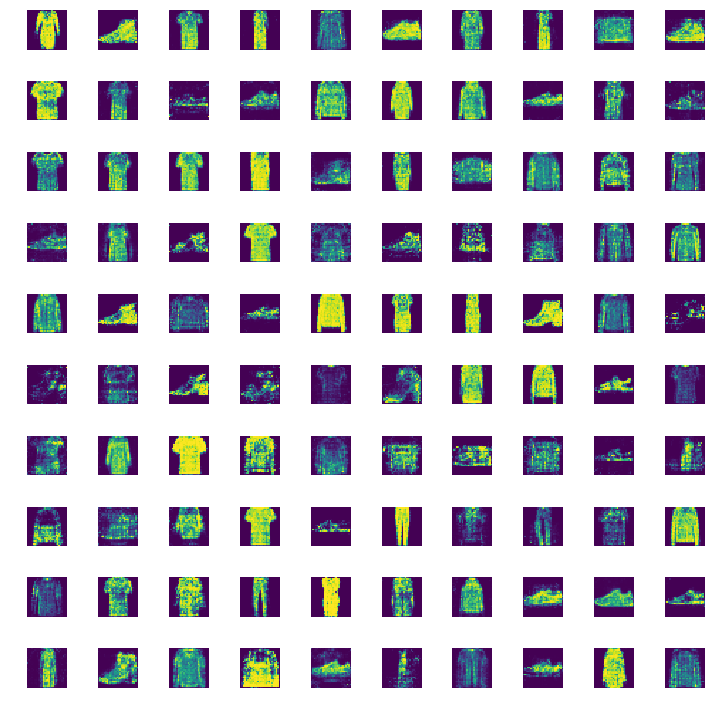

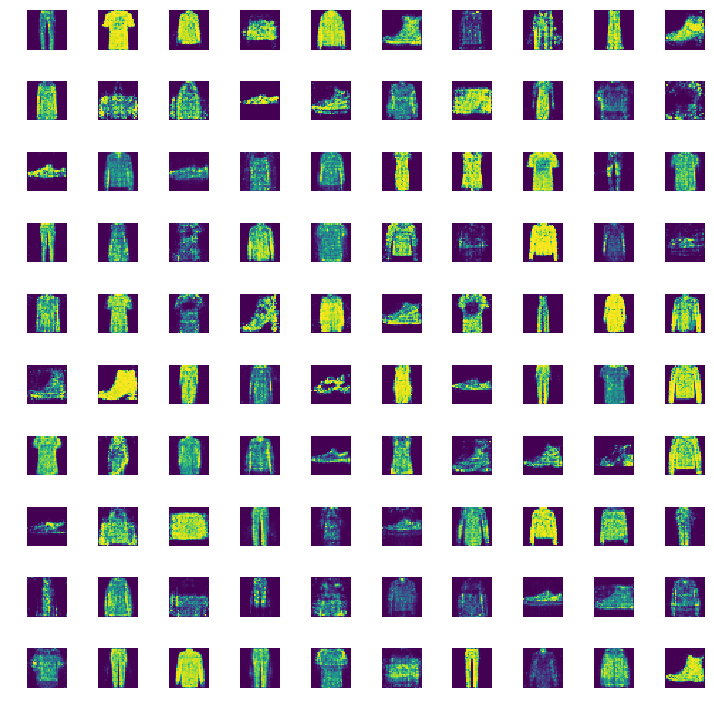

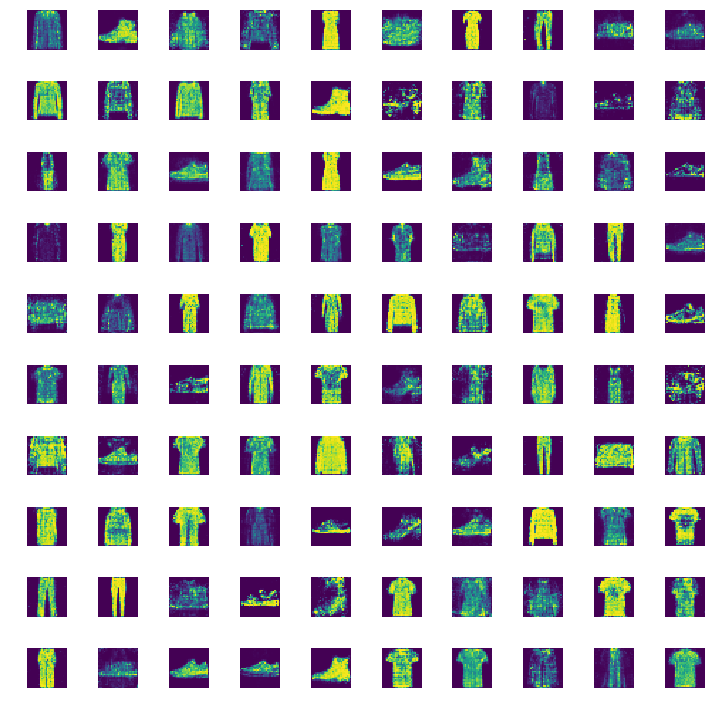

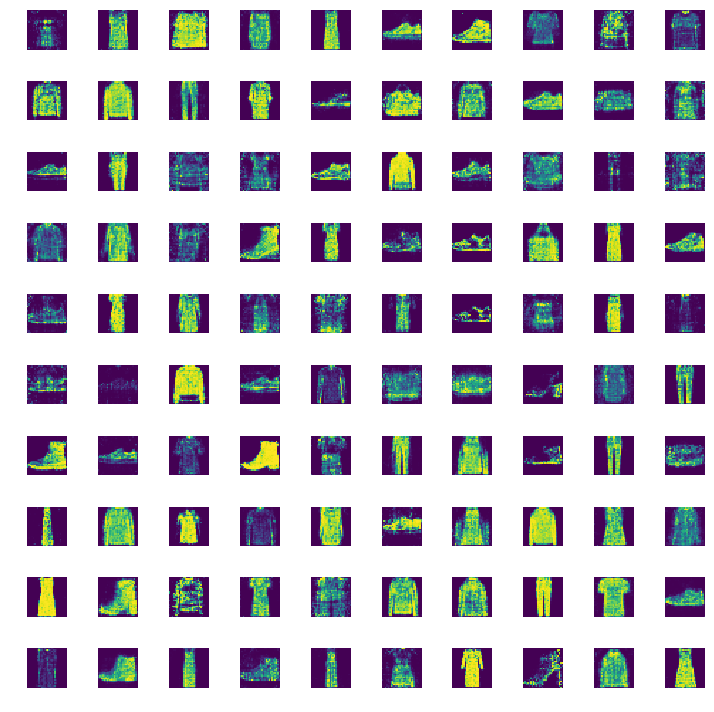

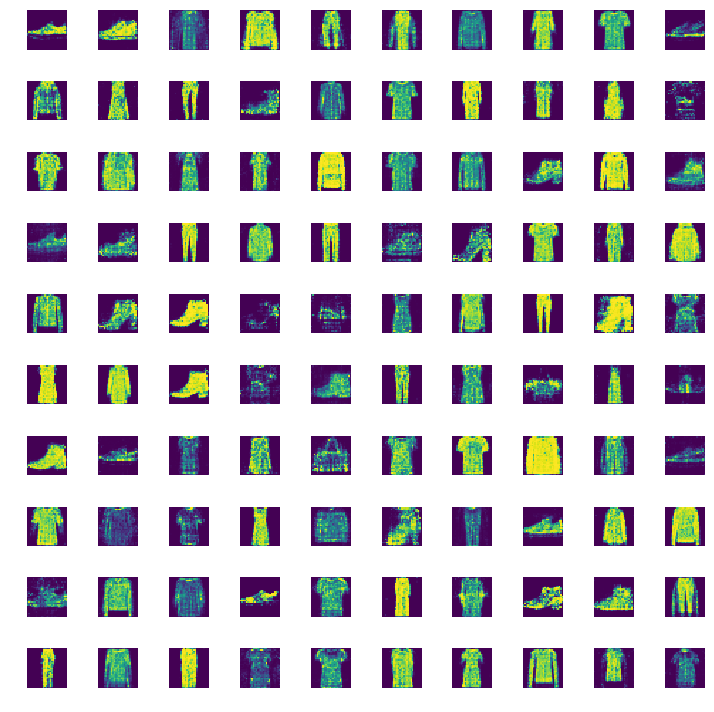

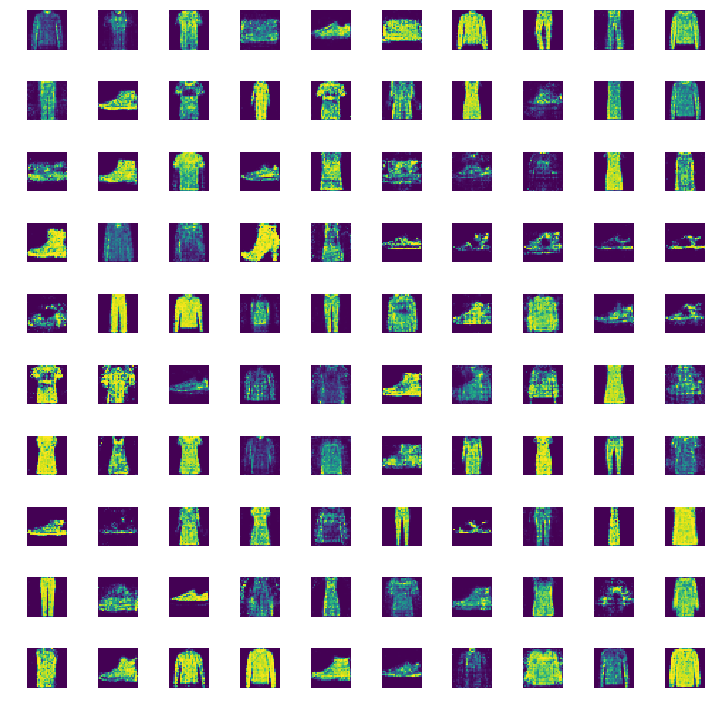

In [20]:
from tqdm import tqdm
def training(X_train, y_train, X_test, y_test, epochs=1, batch_size=128):
    
    #Loading the data
    
    X_train = X_train.reshape(60000, 784)
    batch_count = X_train.shape[0] / batch_size
    
    # Building the GAN
    
    generator= build_generator()
    discriminator= build_discriminator()
    gan = build_gan(discriminator, generator)
    
    # Training process
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            
            noise= np.random.normal(0,1, [batch_size, 100]) # random noise as an input  to  initialize the  generator
            generated_images = generator.predict(noise) #fake MNIST images from previous noise
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)] #random sample of real images
            X= np.concatenate([image_batch, generated_images]) #build batches mixing real and fake data
            
            y_dis=np.zeros(2*batch_size) #labels for fake data
            y_dis[:batch_size]=0.9 #labels for real data
             
            discriminator.trainable=True #We train the parameters of the discriminator
            discriminator.train_on_batch(X, y_dis) #training discriminator (generator is fixed here)
            
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size) # We fix the images generated by the generator as real
            
            discriminator.trainable=False #We fix now the params of the discriminator in order to train the generator
            gan.train_on_batch(noise, y_gen)
            
        # For the first epoch and every multiple of 20 we visualize the generated images in order to check the improvement of the model
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
    
    return generator, discriminator, gan
(generator, discr, gan) = training(x_train,training_labels, x_test, test_labels, 400,128)

Now we have already trained the whole model and we have a generator trained. Let's test it with some new data and check for the results. We generate some new noise:

In [21]:
new_noise = np.random.normal(0,1, [128, 100])

We pass this noise to the trained generator:

In [22]:
images_unprocessed = generator.predict(new_noise)

In [23]:
images_unprocessed.shape

(128, 784)

We reshape the data in order to get the images back and plot them:

Image 1


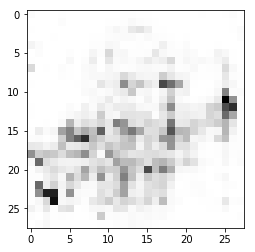

Image 2


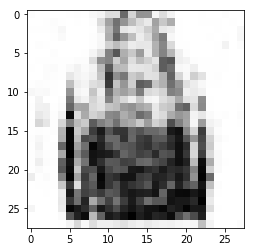

Image 3


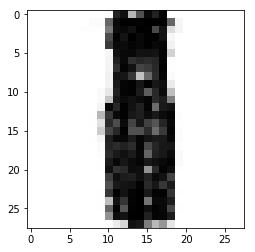

Image 4


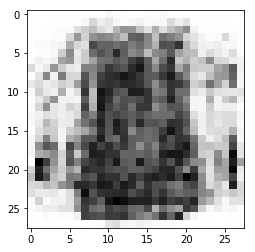

Image 5


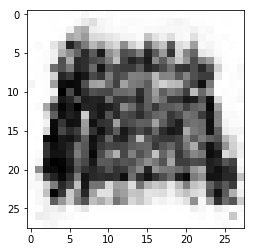

Image 6


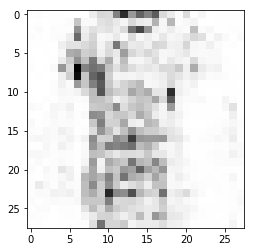

Image 7


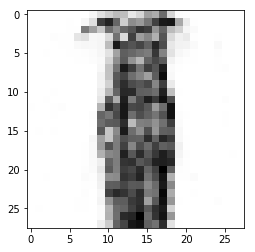

Image 8


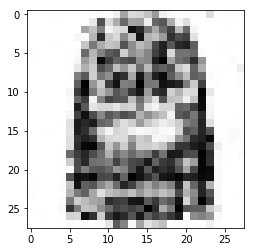

Image 9


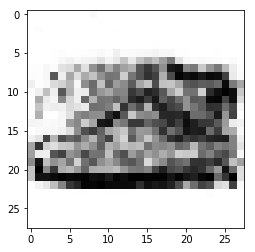

Image 10


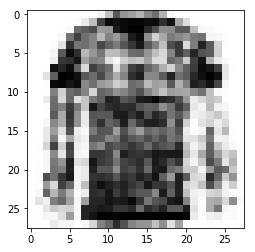

Image 11


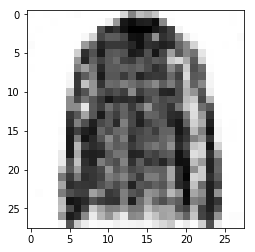

Image 12


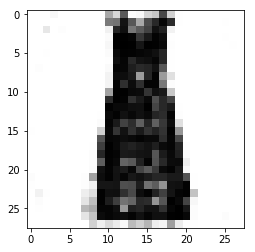

Image 13


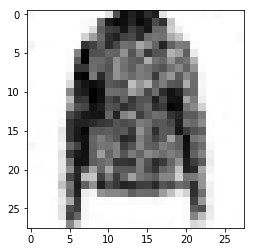

Image 14


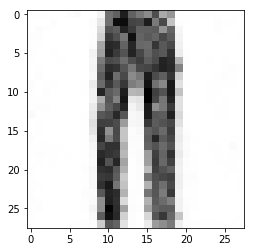

Image 15


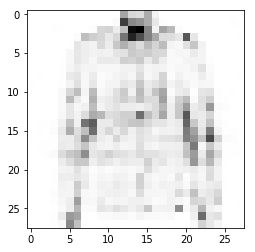

Image 16


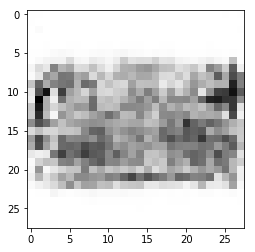

Image 17


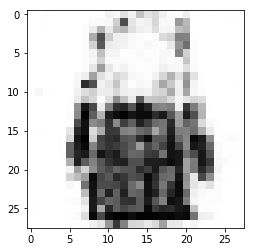

Image 18


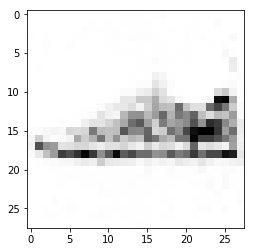

Image 19


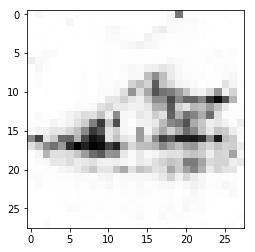

Image 20


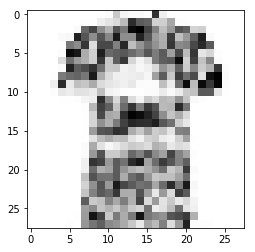

Image 21


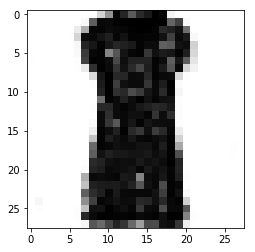

Image 22


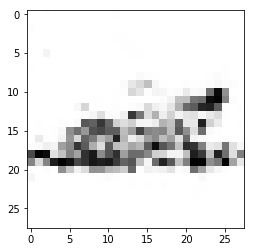

Image 23


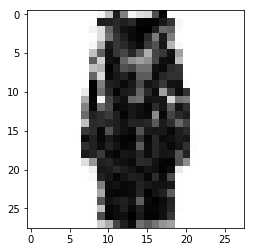

Image 24


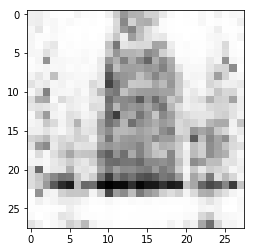

Image 25


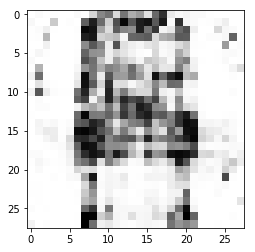

Image 26


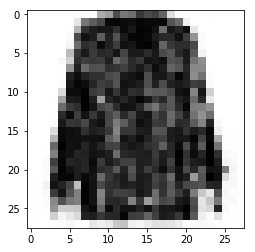

Image 27


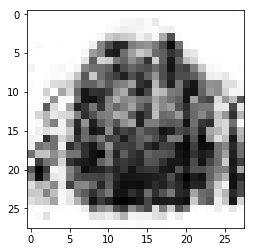

Image 28


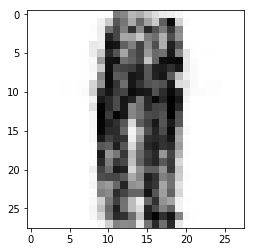

Image 29


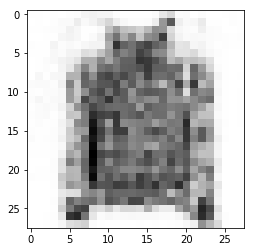

Image 30


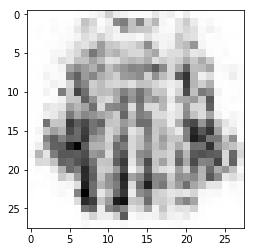

Image 31


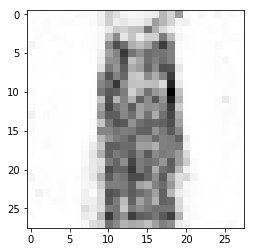

Image 32


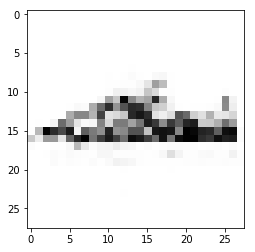

Image 33


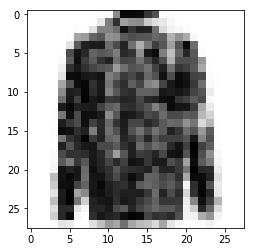

Image 34


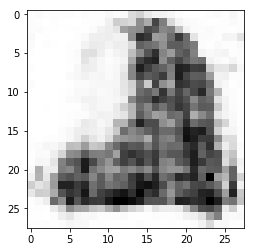

Image 35


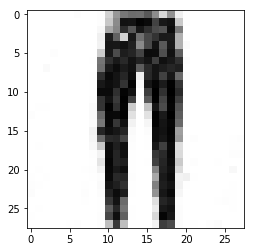

Image 36


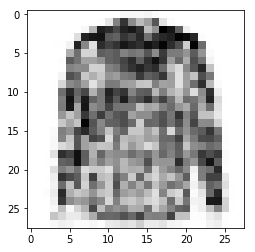

Image 37


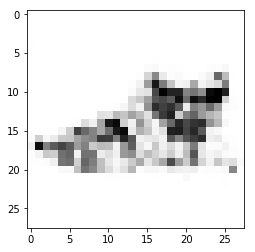

Image 38


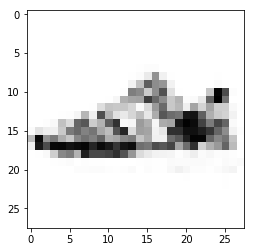

Image 39


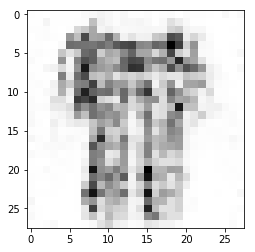

Image 40


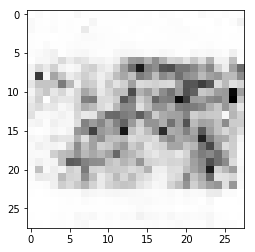

Image 41


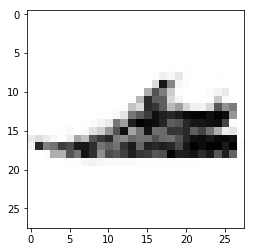

Image 42


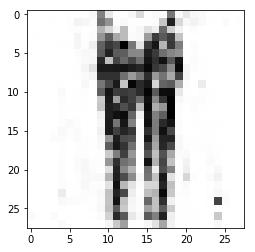

Image 43


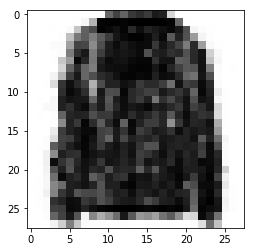

Image 44


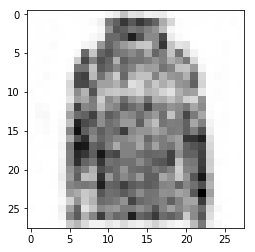

Image 45


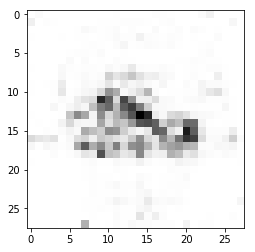

Image 46


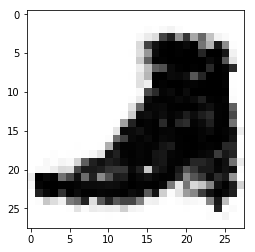

Image 47


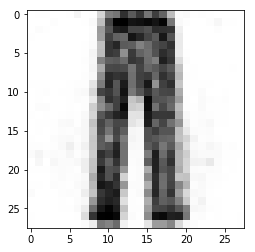

Image 48


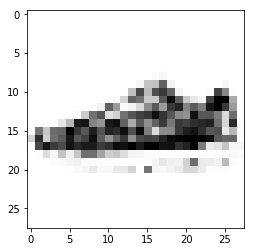

Image 49


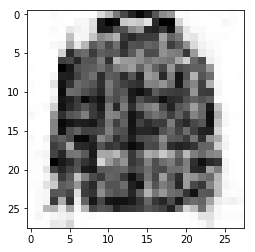

Image 50


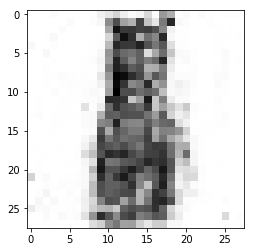

Image 51


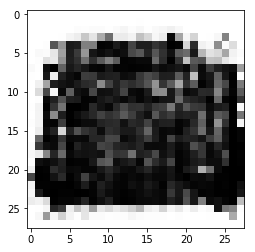

Image 52


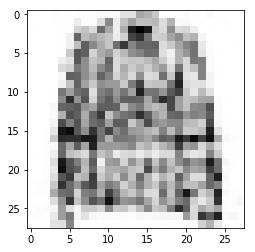

Image 53


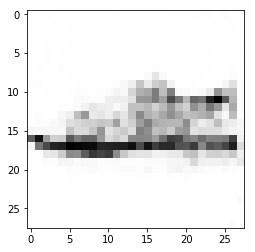

Image 54


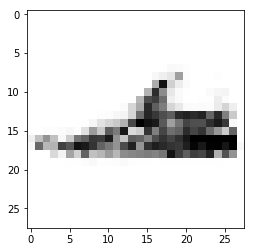

Image 55


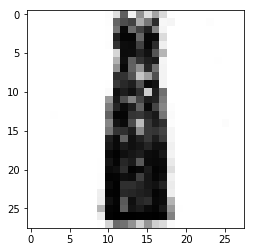

Image 56


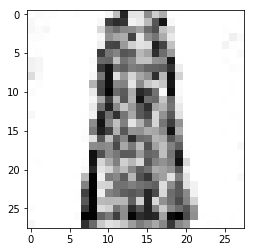

Image 57


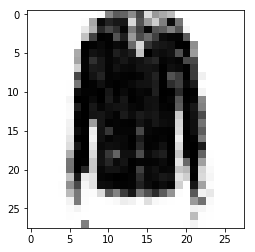

Image 58


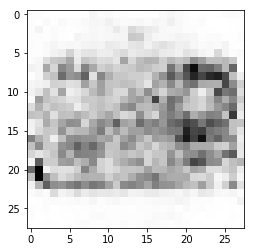

Image 59


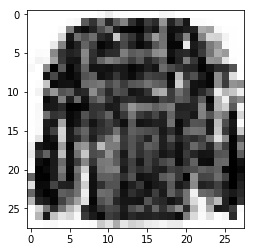

Image 60


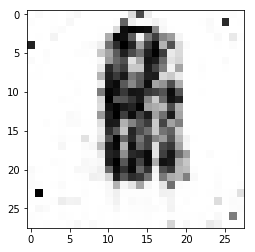

Image 61


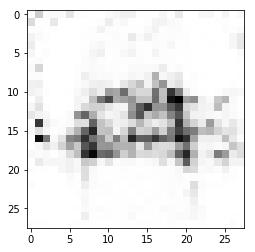

Image 62


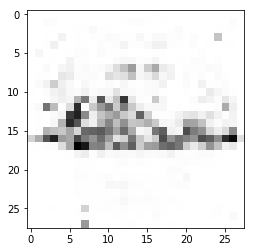

Image 63


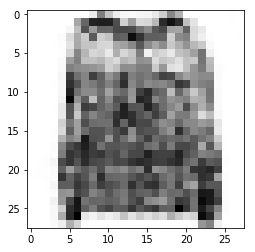

Image 64


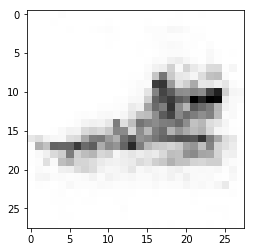

Image 65


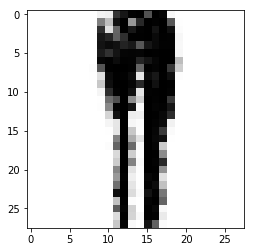

Image 66


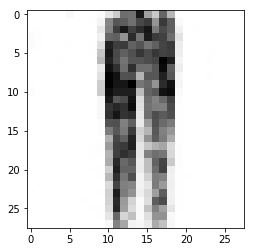

Image 67


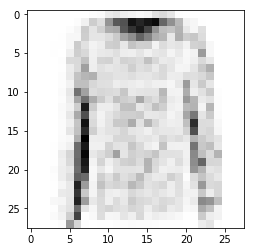

Image 68


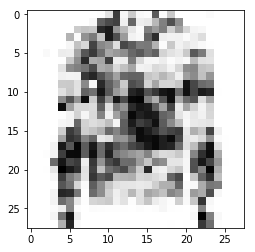

Image 69


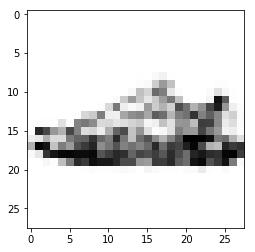

Image 70


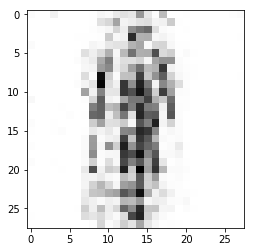

Image 71


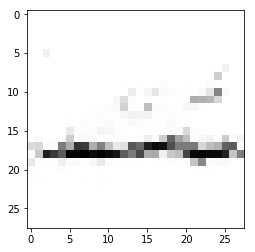

Image 72


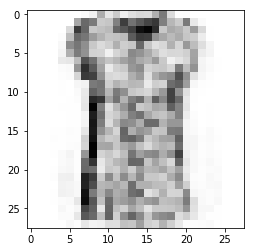

Image 73


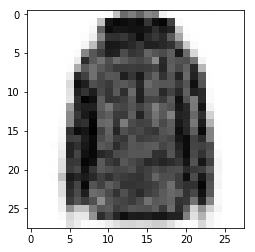

Image 74


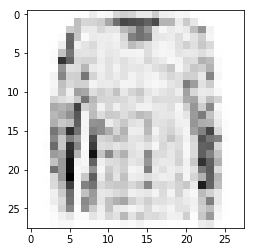

Image 75


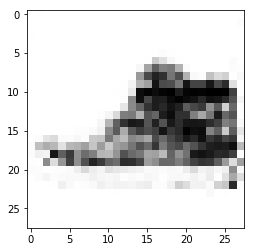

Image 76


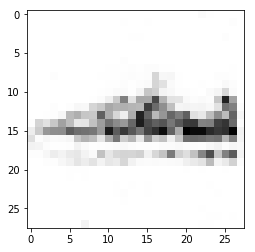

Image 77


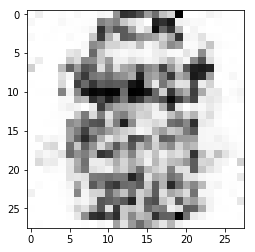

Image 78


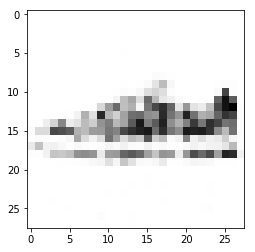

Image 79


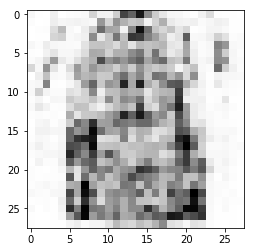

Image 80


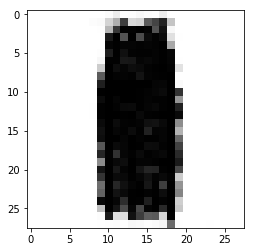

Image 81


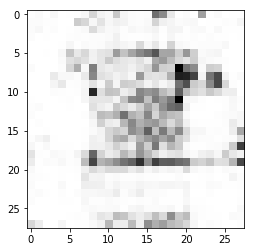

Image 82


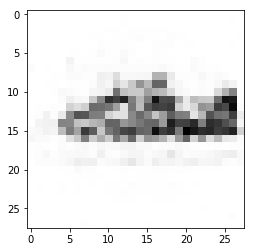

Image 83


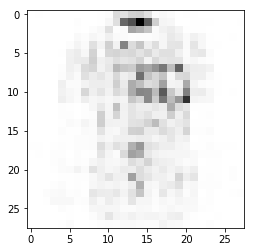

Image 84


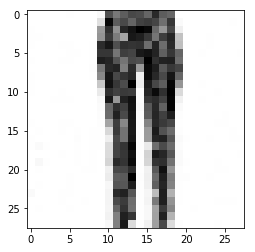

Image 85


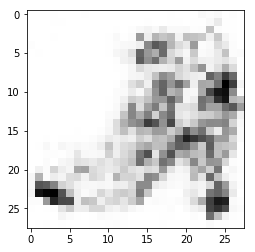

Image 86


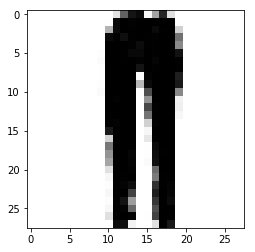

Image 87


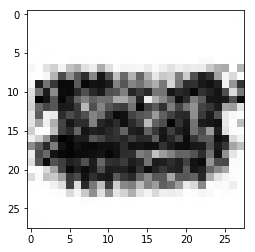

Image 88


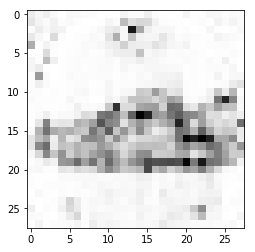

Image 89


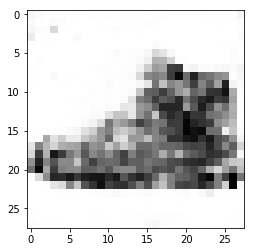

Image 90


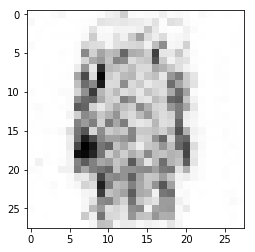

Image 91


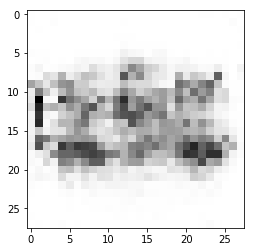

Image 92


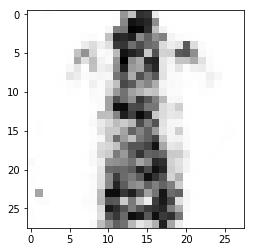

Image 93


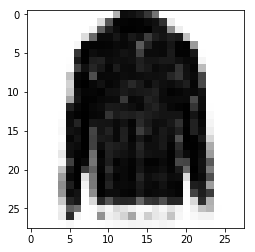

Image 94


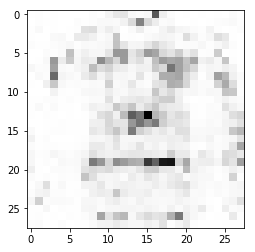

Image 95


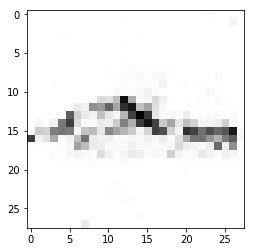

Image 96


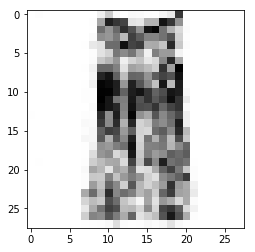

Image 97


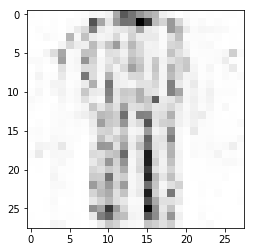

Image 98


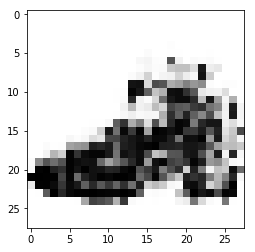

Image 99


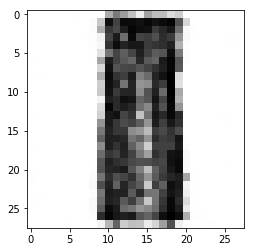

Image 100


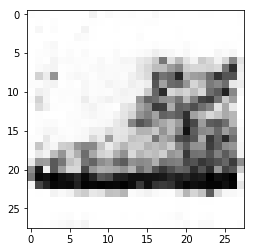

Image 101


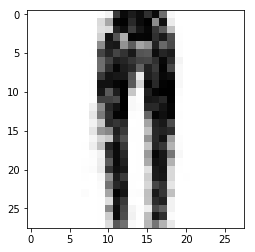

Image 102


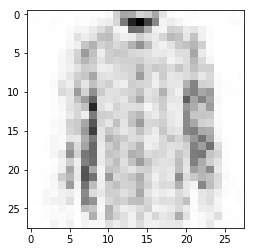

Image 103


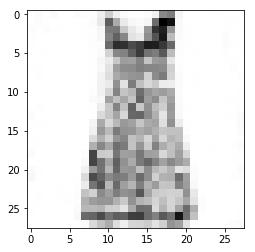

Image 104


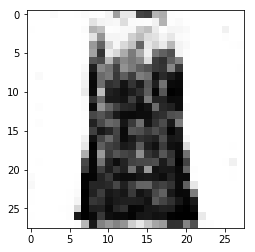

Image 105


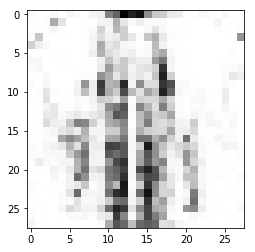

Image 106


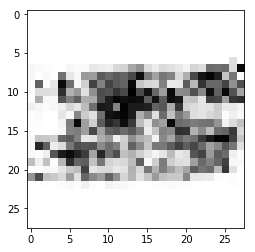

Image 107


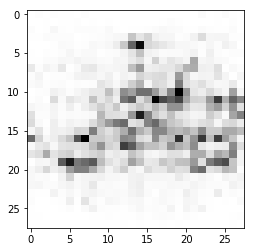

Image 108


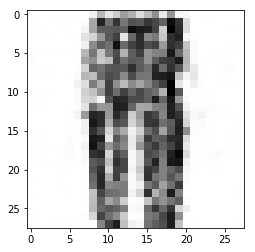

Image 109


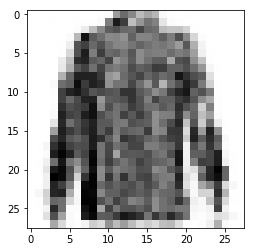

Image 110


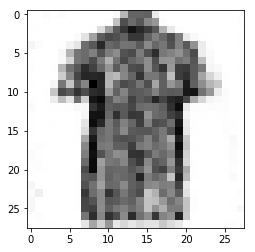

Image 111


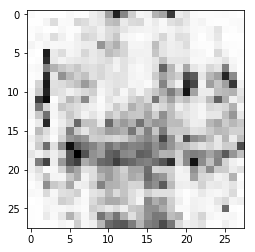

Image 112


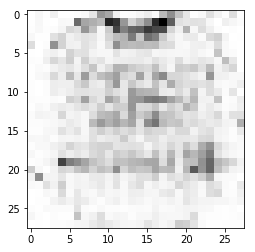

Image 113


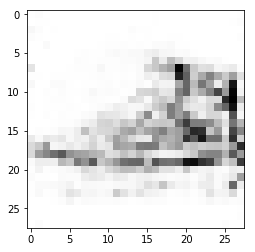

Image 114


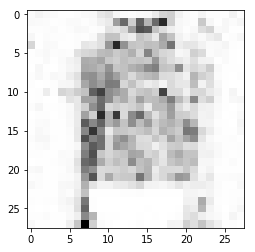

Image 115


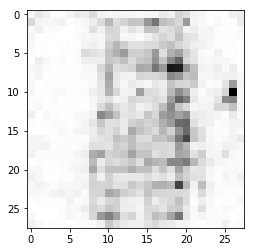

Image 116


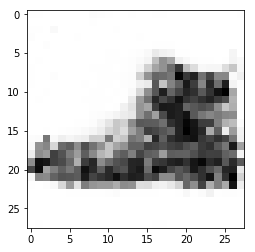

Image 117


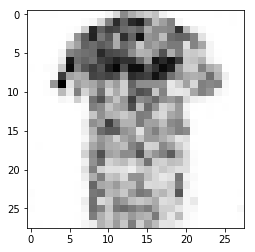

Image 118


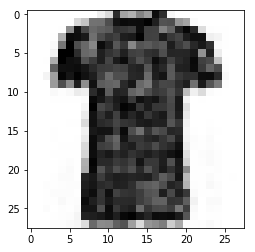

Image 119


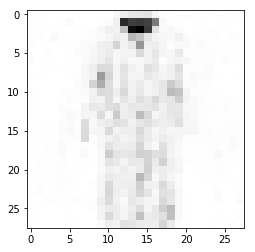

Image 120


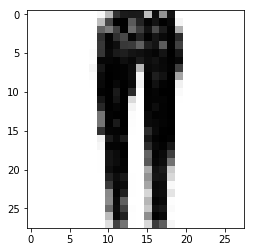

Image 121


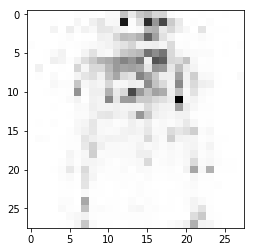

Image 122


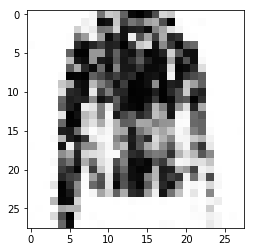

Image 123


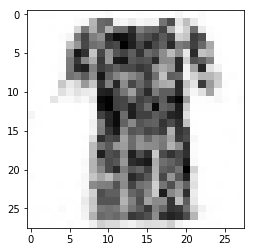

Image 124


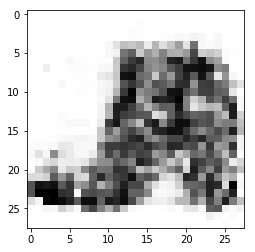

Image 125


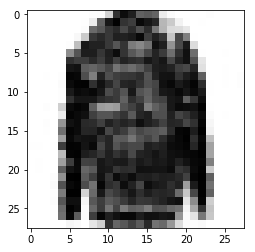

Image 126


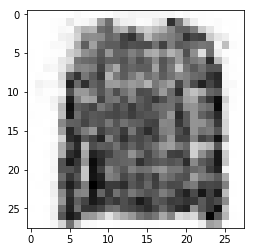

Image 127


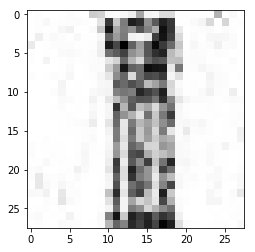

Image 128


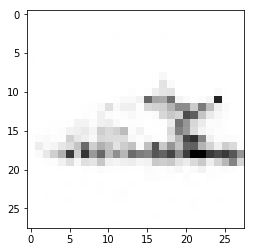

In [24]:
index = 0
for image in images_unprocessed:
    index += 1
    print("Image",index)
    plt.figure()
    plt.imshow(image.reshape(28,28), cmap='Greys');
    plt.show()

The results seem actually quite promising!!